In this notebook we will use how counties in California voted on the questions they were asked at local elections as well as the results of presidential elections. We are going to classify these questions into a few categories (such as education, safety, health) with supervised learning. Then, using unsupervised learning, we will cluster the counties according to how they voted in those categories. We will then see how this matches with presidential elections only, where counties are naturally divided in two sets. The idea is to see whether one needs to look at US politics beyond the two-party system. This is particularly interesting when we allow for more than 2 clusters. Check out the results here http://www.its.caltech.edu/~jgleyzes/dataproject.html

# Preparing the full set of data

In [1]:
import numpy as np
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from math import pi
from sklearn.cluster import KMeans
from matplotlib import rc
rc('text', usetex=True)
%matplotlib inline
import folium
import base64
from folium  import IFrame

Here we prepare the data from the local elections

In [2]:
df_original_data = pd.read_excel('data/ceda1996data.xls')    
for i in range(1997,2011):
    dfaux = pd.read_excel('data/ceda%sdata.xls'%i)

    df_original_data = pd.concat([df_original_data,dfaux])
    
for i in range(2011,2017):
    dfaux = pd.read_excel('data/ceda%sdata.xlsx'%i)

    df_original_data = pd.concat([df_original_data,dfaux])


df_pollingdata = df_original_data.copy()

df_pollingdata['PercentYes'] = df_pollingdata['YES']/df_pollingdata['TOTAL']
df_pollingdata['PercentYesbinned'] = pd.cut(df_pollingdata['PercentYes'],4)
df_pollingdata['OUTCOME'] = -2*df_pollingdata['OUTCOME']+3
df_pollingdata['RECTOPNAME'] = df_pollingdata['RECTOPNAME'].str.replace('.','')
df_pollingdata['CNTYNAME'] = df_pollingdata['CNTYNAME'].str.lower().replace('toulumne','tuolumne').replace('san bernadino', 'san bernardino')


Here we prepare the data from presidential elections (stored in a dictionary according to the year)

In [3]:
df_presidentialresults_2016 = pd.read_excel('data/2016_pres.xls')

for name in df_presidentialresults_2016.columns:
    if '(W/I)' in df_presidentialresults_2016.iloc[0][name]:
        del df_presidentialresults_2016[name]
    elif name !='Votes not Cast':
        namepparty = df_presidentialresults_2016.iloc[0][name]+'_2016'
        df_presidentialresults_2016.rename(columns={name:namepparty},inplace=True)
    
df_presidentialresults_2016 = df_presidentialresults_2016.drop(['  Percent',np.nan]).apply(lambda x: x/x.sum(), axis=1)


df_presidentialresults_2012 = pd.read_excel('data/2012_pres.xls')
for name in df_presidentialresults_2012.columns:
    if '(W/I)' in df_presidentialresults_2012.iloc[0][name]:
        del df_presidentialresults_2012[name]
    elif  name !='Votes not Cast':
        namepparty = df_presidentialresults_2012.iloc[0][name]+'_2012'
        df_presidentialresults_2012.rename(columns={name:namepparty},inplace=True)
df_presidentialresults_2012 = df_presidentialresults_2012.drop(['  Percent',np.nan]).apply(lambda x: x/x.sum(), axis=1)


df_presidentialresults_2008 = pd.read_excel('data/2008_pres.xls')
for name in df_presidentialresults_2008.columns:
    if '(W/I)' in df_presidentialresults_2008.iloc[0][name]:
        del df_presidentialresults_2008[name]
    elif  name !='Votes not Cast':
        namepparty = df_presidentialresults_2008.iloc[0][name]+'_2008'
        df_presidentialresults_2008.rename(columns={name:namepparty},inplace=True)
df_presidentialresults_2008 = df_presidentialresults_2008.drop(['  Percent',np.nan]).apply(lambda x: x/x.sum(), axis=1)


df_presidentialresults_2004 = pd.read_excel('data/2004_pres.xls')
for name in df_presidentialresults_2004.columns:
    if name !='Votes not Cast' and '(W/I)' in df_presidentialresults_2004.iloc[0][name]:
        del df_presidentialresults_2004[name]
    elif  name !='Votes not Cast':
        namepparty = df_presidentialresults_2004.iloc[0][name]+'_2004'
        df_presidentialresults_2004.rename(columns={name:namepparty},inplace=True)
df_presidentialresults_2004 = df_presidentialresults_2004.drop(['  Percent',np.nan]).apply(lambda x: x/x.sum(), axis=1)


df_presidentialresults_2000 = pd.read_excel('data/2000_pres.xlsx')
df_presidentialresults_2000 = df_presidentialresults_2000[df_presidentialresults_2000.columns.drop(list(df_presidentialresults_2000.filter(regex='Unnamed')))]
for name in df_presidentialresults_2000.columns:
    if  name !='Votes not Cast':
        namepparty=name+'_2000'
        df_presidentialresults_2000.rename(columns={name:namepparty},inplace=True)
df_presidentialresults_2000 = df_presidentialresults_2000.dropna().drop(['Percent',np.nan]).apply(lambda x: x/x.sum(), axis=1)


dict_presidential_years = {'2000': df_presidentialresults_2000,'2004': df_presidentialresults_2004,'2008': df_presidentialresults_2008,'2012': df_presidentialresults_2012,'2016': df_presidentialresults_2016}  



# Classification positive/negative BALQUEST
Before we classify the questions into categories, we need to know if the text will be in favor of the category, or against it. The typical example here are taxes: we can classify the question into positive (tax increase) and negative (tax repeal). We will use this to train a classifier. Then, according to the result, we will change the columns 'PercentYes' to always reflect a positive view on the category.

Select the questions which concern tax increase (to model positive question) and tax repeal (to model negative question)


In [4]:
mask_positivenegative = df_pollingdata['RECTOPNAME'].isin(['Revenues: Tax Creation/Incr/Contin','Revenues: Tax Repeal/Reduction/Limit'])

df_pos_neg = df_pollingdata[mask_positivenegative].replace({'RECTOPNAME':{'Revenues: Tax Creation/Incr/Contin':1,'Revenues: Tax Repeal/Reduction/Limit':-1}})
X_data_posneg = df_pos_neg['BALQUEST'].dropna().str.lower().str.replace('city','').str.replace('charter','').str.replace('shall','').str.replace('should','').str.replace('county','').str.replace('\d+', '').str.replace('$', '').str.replace('no.', '')

Train the vectorizer

In [5]:
df_pollingdata_nonan = df_pollingdata.dropna(axis=0,subset=['BALQUEST'])

#Remove a few common strings to help vectorizer
df_text_questions = df_pollingdata_nonan['BALQUEST'].str.lower().str.replace('bonds','').str.replace('city','').str.replace('charter','').str.replace('shall','').str.replace('should','').str.replace('county','').str.replace('\d+', '').str.replace('$', '').str.replace('no.', '')

fullcorpus = df_text_questions.copy()
tvecfull = TfidfVectorizer(min_df=.0025, max_df=0.2, stop_words='english', ngram_range=(1,1))
tvecfull.fit(fullcorpus)

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.2, max_features=None, min_df=0.0025,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

Train the classifier

In [6]:
X_datavec_posneg = tvecfull.transform(X_data_posneg)
y_data_posneg = df_pos_neg['RECTOPNAME']
X_train, X_test, y_train, y_test = train_test_split(X_datavec_posneg, y_data_posneg,random_state=20)
clf = GradientBoostingClassifier(learning_rate = 0.08, max_depth = 3, random_state = 0,n_estimators=40).fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'     .format(clf.score(X_test, y_test)))

fullcorpus_vec = tvecfull.transform(fullcorpus)

#Applies classifier to full corpus of questions
Solpredict_posneg = clf.predict(fullcorpus_vec)

Accuracy of Decision Tree classifier on training set: 0.96
Accuracy of Decision Tree classifier on test set: 0.92


# Classification Topic Balquest

We choose to classify the questions into six types: 
'education','safety','health','facilities','recall','tourism'. We also create a category for the questions that correspond to none of the above. We will train a classifier on the questions that contain explicitly the name of the label (and only that name). Then, we will apply the classifier to the ensemble of questions to determine which category they belong to.

In [7]:
labels = ['education','safety','health','facilities','recall','tourism']

Removes name of counties from the corpus since they should not matter in the classification

In [8]:
for name in np.unique(df_pollingdata['CNTYNAME'].values):
        df_text_questions = df_text_questions.str.replace(name,'')
    
for name in np.unique(df_pollingdata['PLACE'].str.lower().values):
        df_text_questions = df_text_questions.str.replace(name,'')

 If label PosNeg is +1, we keep the percentage of Yes. If it's -1, it means the question is negative. 
 Therefore, to only have percentage for acceptance (not rejection) we replace 'PercentYes' by 1-'PercentYes'

In [9]:
df_pollingdata_Pos_only = df_pollingdata_nonan.copy()
df_pollingdata_Pos_only['PosNeg'] = Solpredict_posneg
df_pollingdata_Pos_only.loc[df_pollingdata_Pos_only['PosNeg']==-1,'PercentYes'] = 1-df_pollingdata_Pos_only.loc[df_pollingdata_Pos_only['PosNeg']==-1,'PercentYes']

Remove a few topics that are not interesting to limit number of features and improve classifier performance.


In [10]:
df_pollingdata_Pos_only.loc[(df_pollingdata_Pos_only['RECTOPNAME'].str.lower().str.contains('governance'))|(df_pollingdata_Pos_only['RECTOPNAME'].str.lower().str.contains('zoning'))|(df_pollingdata_Pos_only['RECTOPNAME'].str.lower().str.contains('land')),'TopicName']='other'

Here, we assign a label 'TopicName' to everyone. Then, if a question in df_text_questions contains one of the terms
in the list 'labels', and only that term, we change 'TopicName' to that question. All the others are assigned a 'TopicName' = 'notopic' as default.


In [11]:
df_pollingdata_Pos_only['TopicName'] = 'notopic'
for term in labels:
    excluded = "|".join(np.setxor1d(labels, [term]))
    df_pollingdata_Pos_only.loc[(df_text_questions.str.contains(term))&(df_text_questions.str.contains(excluded)==False),'TopicName'] = term

We use a different vectorizer, containing only 2-grams, because we want more causality

In [12]:
tvec = TfidfVectorizer(min_df=.0015, max_df=0.07, stop_words='english', ngram_range=(2,2))
tvec_weights = tvec.fit_transform(df_text_questions)
tvocab = np.array(tvec.get_feature_names())

We apply the vectorizer to the dataframe

In [13]:
X_datatopic = df_pollingdata_Pos_only.loc[(df_pollingdata_Pos_only['TopicName']!='notopic')]['BALQUEST']
X_datatopic_vec = pd.DataFrame(tvec.transform(X_datatopic).todense(), columns=tvocab,index=X_datatopic.index)
y_datatopic = df_pollingdata_Pos_only.loc[(df_pollingdata_Pos_only['TopicName']!='notopic'),'TopicName']


X_remain = df_pollingdata_Pos_only.loc[(df_pollingdata_Pos_only['TopicName']=='notopic')]['BALQUEST']
X_remain_vec = pd.DataFrame(tvec.transform(X_remain).todense(), columns=tvocab,index=X_remain.index)


We normalize the data

In [14]:
scaler = StandardScaler()
X_traintopic, X_testtopic, y_traintopic, y_testtopic = train_test_split(X_datatopic_vec, y_datatopic,random_state=20)
scaler.fit(X_traintopic)
X_trainprocessed = scaler.transform(X_traintopic)
X_testprocessed = scaler.transform(X_testtopic)

We fit the classifier and apply it to the questions

In [15]:
clftop = RandomForestClassifier(n_estimators=200,max_features = 10,random_state=0).fit(X_trainprocessed, y_traintopic)#GradientBoostingClassifier(learning_rate = 0.1, max_depth = 6, random_state = 0,n_estimators=60).fit(X_trainprocessed, y_traintopic)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clftop.score(X_trainprocessed, y_traintopic)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
      .format(clftop.score(X_testprocessed, y_testtopic)))

Accuracy of Decision Tree classifier on training set: 0.99
Accuracy of Decision Tree classifier on test set: 0.85


Assign the predicted labels to the questions

In [16]:
topredict = scaler.transform(X_remain_vec)
df_pollingdata_Pos_only.loc[df_pollingdata_Pos_only['TopicName']=='notopic','TopicName'] = clftop.predict(topredict)

Repartion of labels

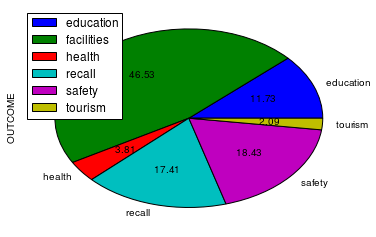

In [17]:
df_pollingdata_Pos_only.groupby(['TopicName']).agg({'OUTCOME':np.size}).plot.pie(y='OUTCOME', autopct='%.2f')
plt.show()

# Preparing the maps
Now that we have the data cleaned in df_pollingdata_Pos_only, we can prepare the maps

In [46]:
def computelabel(Yearmin,Yearmax,df_pollingdata_Pos_only,nclust=2,labels=labels):
    """
    Compute the labels for the counties
    
    Arguments:
    Yearmax -- the maximum year to be included
    Yearmin -- the minimum year to be included (typically, = Yearmax -4 to match with presidential cycles) 
    df_pollingdata_Pos_only -- the dataframe containing the whole electoral data (Ballot questions)
    
    Returns: 
    dfCNTYmerge -- the list of counties with their clustering labels and mean vote in the 5 categories
    dfclustlabel --  the positions of the clusters center in the space of categories
    """
                        #######################################################################
                        ###  Prepare the dataframe with counties and mean vote per category ###
                        #######################################################################
                
    #Choose the relevant years
    dfreduced = df_pollingdata_Pos_only[(df_pollingdata_Pos_only['YEAR']>=Yearmin)&(df_pollingdata_Pos_only['YEAR']<=Yearmax)].dropna(axis=0,subset=['BALQUEST'])#[(df_pollingdata['RECTOPNAME'] == 'Education: Bonds')| (df_pollingdata['RECTOPNAME'] == 'Revenues: Tax Creation/Incr./Contin.') | (df_pollingdata['RECTOPNAME'] == 'Education')]
    dfpres = dict_presidential_years[str(Yearmax)].copy()

    dfpres.index = dfpres.index.str.lower()

    dfpres['Winner'] = dfpres.idxmax(axis=1).str[:3]
    dfpres = dfpres.replace({'Winner':{'REP':-1,'DEM':1}})
    
    #Prepare the feature space for the clusters (average yes vote per topic)
    dfClustermean = dfreduced.groupby(['CNTYNAME','TopicName']).agg({'PercentYes':[np.mean]})
    dfClustermean.columns = dfClustermean.columns.droplevel(0)
    
    dfCNTYmean = dfClustermean.unstack(level=-1).replace(np.nan,0.5)
    dfCNTYmean.columns = dfCNTYmean.columns.droplevel(0)
    del dfCNTYmean.index.name
    del dfCNTYmean.columns.name

    dfCNTY_scaled = pd.DataFrame(scaler.fit_transform(dfCNTYmean),columns=dfCNTYmean.columns,index=dfCNTYmean.index)
    
    #Merge percentage presidential elections
    dfCNTY_plus_percentPres = pd.merge(dfCNTY_scaled,dfpres[np.setxor1d(dfpres.columns, ['Winner'])],left_index=True,right_index=True)

                            ########################################################
                            ###  Use KMeans clustering to define nclust clusters ###
                            ########################################################
    

    kmeans = KMeans(n_clusters=nclust, random_state=0,n_init=30,max_iter=1000).fit(scaler.fit_transform(dfCNTY_plus_percentPres))
    SeriesLabel = pd.Series(kmeans.labels_,index=dfCNTY_plus_percentPres.index)
    
    #Change Label from "i" to 'Lab'+str(i) as well as assigning nan to 'Lab'+str(nclust)
    toreplace = range(nclust) + [np.nan]
    values = ['Lab' + str(i) for i in range(nclust+1)]
    
    dfCNTY_plus_percentPres['Label'] = SeriesLabel.replace(to_replace=toreplace,value=values)
    
    dfCNTYmerge = pd.merge(dfCNTY_plus_percentPres,dfpres,how='left',left_index=True,right_index=True)
    
    #Order the labels from most Dem to most Rep at the presidential elections
    #orderlabelDemtoRep = np.array([ dfCNTYmerge[dfCNTYmerge['Label']==i]['Winner'].mean() for i in range(nclust)]).argsort()[::-1]
    
    #Change the label so that Lab0 is the most democratic at presidential elections
    #changelabel = {orderlabelDemtoRep[l]: 'Lab%s'%l for l in range(nclust)}
    #dfCNTYmerge = dfCNTYmerge.replace({"Label": changelabel})
    
    #Get the center of the clusters, sorted from most important to least
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    
    terms = dfCNTY_plus_percentPres.columns
    clusterlabels = {}
    for i in range(nclust):
        clusterlabels['Lab'+str(i)]={}
        for ind in order_centroids[i, :]:
            clusterlabels['Lab'+str(i)][terms[ind]] = kmeans.cluster_centers_[i,ind]
    
    #Saves the coordinates of the centers in a dataframe
    dfclustlabel = pd.DataFrame.from_dict(clusterlabels,orient='index')
    
    
    dfCNTYmerge[labels] = dfCNTYmerge[labels]-dfCNTYmerge[labels].min()
    dfCNTYmerge[labels] = dfCNTYmerge[labels]/dfCNTYmerge[labels].max()

    
    return [dfCNTYmerge,dfclustlabel]

We will attach a "spider plot" to each county to show how it voted.

In [26]:
def plotspider(df,color,label,lw=2,alpha=0.8,ls='-'):
# number of variable
    categories=df.index
    N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
    values=df.values.tolist()
    values += values[:1]
    values
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
 
# Initialise the spider plot
    ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels labels yet
    plt.xticks(np.array(angles[:-1]), categories, color='black', size=18)
 
# Draw ylabels
    ax.set_rlabel_position(160)
    plt.yticks([0,0.25,0.5,0.75,1], ["0",'',"0.5",'',"1"], color="black", size=18)
    plt.ylim(0,1)
 
# Plot data
    ax.plot(angles, values, linewidth=lw, linestyle='solid',color=color,label=label,alpha=alpha,ls=ls)
    ax.plot(np.linspace(0.0, 2*np.pi,100), 0.5*np.ones(100),color='grey',alpha=0.6,lw=2,ls='--') 
 
# Fill area
    ax.fill(angles, values, color, alpha=0.)
    
    return ax


We name the label according to how they voted for the presidential election.

In [27]:
dictPercentDEMtoLabel = {}
arraypercentDEM = [float(dfCNTYmerge.loc[(dfCNTYmerge['Label']==label)&(dfCNTYmerge['Winner']==1)].shape[0])/dfCNTYmerge.loc[(dfCNTYmerge['Label']==label),'Winner'].shape[0] for label in np.unique(dfCNTYmerge['Label'].values)]

for label in np.unique(dfCNTYmerge['Label'].values):
        propDEM = float(dfCNTYmerge.loc[(dfCNTYmerge['Label']==label)&(dfCNTYmerge['Winner']==1)].shape[0])/dfCNTYmerge.loc[(dfCNTYmerge['Label']==label),'Winner'].shape[0] 
        if propDEM >= np.array(arraypercentDEM).max():
            labelname = 'Strong DEM'
        elif propDEM > 0.5 and propDEM <= np.array(arraypercentDEM).max():
            labelname =  'Outliers DEM'
        elif propDEM > np.array(arraypercentDEM).min() and propDEM <= 0.5:
            labelname = 'Outliers REP'
        else:
            labelname = 'Strong REP'
        dictPercentDEMtoLabel[label] = labelname

Example spider plot for period 2008-2012 and 2 clusters

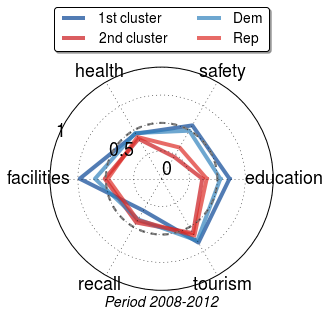

In [47]:
dfCNTYmerge,dfclustlabel = computelabel(2008,2012,df_pollingdata_Pos_only,nclust=4)

#Assign color to each label
colorlabel = {'Strong REP':'#cb181d','Strong DEM':'#084594','Outliers REP':'#cb181d','Outliers DEM':'#4292c6','Labn':'#FFFFFF'}

#Change string label to number
Winnertopres = {'1':'Dem','-1':'Rep'}


plt.clf()
plotspider(dfCNTYmerge.loc[dfCNTYmerge['Label']=='Lab0',labels].mean(),colorlabel[dictPercentDEMtoLabel['Lab0']],'1st cluster',lw=4,alpha=0.7)
plotspider(dfCNTYmerge.loc[dfCNTYmerge['Label']=='Lab1',labels].mean(),colorlabel[dictPercentDEMtoLabel['Lab1']],'2nd cluster',lw=4,alpha=0.7)

plotspider(dfCNTYmerge.loc[dfCNTYmerge['Winner']==1,labels].mean(),'#3182BD','Dem',lw=4,alpha=0.7)
plotspider(dfCNTYmerge.loc[dfCNTYmerge['Winner']==-1,labels].mean(),'#DE2D26','Rep',lw=4,alpha=0.7)

plt.xlabel(r'  \begin{center}\vspace{10cm}\textit{\Large{' + 'Period 2008-2012' + r'}}\end{center}')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
          fancybox=True, shadow=True, ncol=2,fontsize=14)
#plt.savefig('data/figtest.png')
plt.show()

The coordinates of the clusters'center in the multidimensional feature space for this example

In [104]:
dfclustlabel.head()

,LIB_2012,facilities,GRN_2012,recall,PF_2012,health,REP_2012,safety,education,tourism,AI_2012,DEM_2012
Lab0,0.067400,0.548433,0.484689,-0.183189,-0.397780,0.324511,-1.051365,0.661607,0.693927,0.283673,-0.750908,1.050012
Lab1,-0.038254,-0.311273,-0.275094,0.103972,0.225767,-0.184182,0.596721,-0.375507,-0.393851,-0.161004,0.426191,-0.595953


# Plotting on the map

Preparing the JSON data for the map. In particular, assign the gps coordinates of the capital to each county.

In [49]:
with open('data/Cacountiesconvert.json', 'r') as f:
    get_id = json.load(f)

#A little FIPS code type casting to ensure keys match
new_geoms = []
for geom in get_id['features']:
    geom['properties']['NAME'] = geom['properties']['NAME'].lower()
    new_geoms.append(geom)

get_id['features'] = new_geoms

with open('data/Cacountiesconvert.json', 'w') as f:
    json.dump(get_id, f)
geo_json_data = json.load(open('data/Cacountiesconvert.json'))
dflocfull = pd.read_csv('data/countiescapital.csv').rename(columns={'County [2]':'NAME'})
dflocfull['NAME'] = dflocfull['NAME'].str.lower()
dfloc = dflocfull[dflocfull['State']=='CA'][['NAME','Latitude','Longitude']].set_index('NAME')
dfloc['Latitude'] = pd.to_numeric(dfloc['Latitude'].str[:8])
dfloc['Longitude'] = - pd.to_numeric(dfloc['Longitude'].str[3:12])

Putting everything together to create html files (here with choice of nclust = 2)

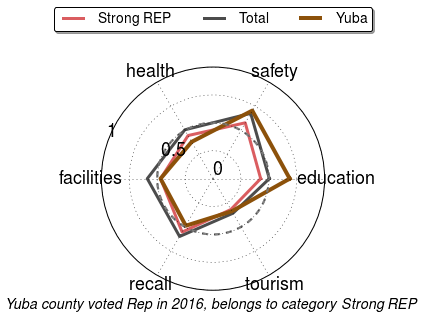

In [53]:
def my_color_function(df,feature):
        if float(df.loc[feature['properties']['NAME'],'Winner']) > 0:
            return '#3182BD'
        else:
            return '#DE2D26'

Winnertopres = {1:'Dem',-1:'Rep'}
map_1 = folium.Map([35,-120], tiles='Mapbox Bright', zoom_start=5)

nclust = 2


def addmapPres(Year,map_1):
    

    dfpres1 = dict_presidential_years[str(Year)].copy()
    dfpres1.index = dfpres1.index.str.lower() 
    dfpres1['Winner'] = dfpres1.idxmax(axis=1).str[:3]
    dfpres1 = dfpres1.replace({'Winner':{'REP':-1,'DEM':1}})
    map_1.add_child(folium.GeoJson(geo_json_data ,
        style_function=lambda feature: {
        'fillColor': my_color_function(dfpres1,feature),
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5',
        'fillOpacity':0.9
        },name='{} Presidential Elections'.format(Year)))

for Year in [2004,2008,2012,2016]:
    addmapPres(Year,map_1)
   

for Yearmax in [2004,2008,2012,2016]:
    
    dfCNTYmerge,dfclustlabel = computelabel(Yearmax-4,Yearmax,df_pollingdata_Pos_only,nclust=nclust)
    
    dfCNTYmerged = pd.merge(dfCNTYmerge,dfloc,how='outer',left_index=True,right_index=True)
    dfCNTYmerged['Label'].replace(np.nan,'Labn',inplace=True)
    
    dfpres = dict_presidential_years[str(Yearmax)].copy()
    dftot = dfCNTYmerge[labels].mean()
    dfpres.index = dfpres.index.str.lower()
    
    dfpres['Winner'] = dfpres.idxmax(axis=1).str[:3]
    dfpres = dfpres.replace({'Winner':{'REP':-1,'DEM':1}})
 
    
    dictPercentDEMtoLabel = {}
    arraypercentDEM = [dfclustlabel.loc[label,'DEM_%s'%Yearmax] for label in np.unique(dfCNTYmerge['Label'].values)]
    strDEM = ''
    strREP = ''
    for label in np.unique(dfCNTYmerge['Label'].values):
        propDEM = dfclustlabel.loc[label,'DEM_%s'%Yearmax] 
        if propDEM >= np.array(arraypercentDEM).max():
            labelname = 'Strong DEM'
        elif propDEM >0 and propDEM<np.array(arraypercentDEM).max():
            labelname = 'Outliers DEM'+strDEM
            strDEM += ' 2nd'
        elif propDEM > np.array(arraypercentDEM).min() and propDEM<=0:
            labelname = 'Outliers REP'+strREP
            strREP += ' 2nd'
        else:
            labelname = 'Strong REP'
        dictPercentDEMtoLabel[label] = labelname
    for name in dfCNTYmerged[dfCNTYmerged['Winner'].isnull()].index:
        dfCNTYmerged.loc[name,'Winner'] = dfpres.loc[name,'Winner']
    for name in dfCNTYmerge.index:
        plt.clf()
        label = dfCNTYmerge.loc[name,'Label']
        
        labelname = dictPercentDEMtoLabel[label]   
        dname = dfCNTYmerge.loc[name,labels]
        
        txt = '{} county voted {} in {}, belongs to category {}'.format(name.title(),Winnertopres[int(dfCNTYmerged.loc[name,'Winner'])]
                                                                  ,Yearmax,labelname)
                    
        dlabel = dfCNTYmerge[dfCNTYmerge['Label']==label][labels].mean()
        labelname = dictPercentDEMtoLabel[label]
        plotspider(dlabel,colorlabel[labelname],labelname,lw=3,alpha=0.7)
        plotspider(dftot,'black','Total',lw=3,alpha=0.7)
        plotspider(dname,'#8c510a',name.title(),lw=4,alpha=1)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
                  fancybox=True, shadow=True, ncol=3,fontsize=14)
        plotspider(dname,'#8c510a',name.title(),lw=4,alpha=0)
        plt.xlabel(r'  \begin{center}\vspace{10cm}\textit{\Large{' + txt + r'}}\end{center}')
        
        plt.savefig('data/Figs/figspidercounty_%syear_%sclust_%s.png'%(name,Yearmax,nclust), bbox_inches='tight')
    
    
    layermarker = folium.FeatureGroup(name = 'Categories Year {}'.format(Yearmax))
    
    for name in dfCNTYmerged.index:
        label = dfCNTYmerged.loc[name,'Label']
        
        
        if label == 'Labn':
            popup = '{} county voted {} in {}, belongs to category {}'.format(name.title(),
                                                                              Winnertopres[int(dfCNTYmerged.loc[name,'Winner'])],
                                                                              Yearmax,'no info')
            layermarker.add_child( folium.RegularPolygonMarker([dfCNTYmerged.loc[name,'Latitude'], dfCNTYmerged.loc[name,'Longitude']],
              popup = popup, number_of_sides = 4,radius = 10,
              fill_color=colorlabel[label], fill_opacity= 1,opacity=0))
        else:
            labelname = dictPercentDEMtoLabel[label]
            
            Filename = 'data/Figs/figspidercounty_%syear_%sclust_%s.png'%(name,Yearmax,nclust)
            encoded = base64.b64encode(open(Filename, 'rb').read())
            resolution, width, height = 30, 16, 10.5
            html = '<img src="data:image/png;base64,{}">'.format
            iframe = IFrame(html(encoded), width=(width*resolution)+10, height=(height*resolution)+10)
            popup = folium.Popup(iframe, max_width=2650)
            layermarker.add_child(folium.RegularPolygonMarker([dfCNTYmerged.loc[name,'Latitude'], dfCNTYmerged.loc[name,'Longitude']],
              popup = popup,
              number_of_sides = 4,
                radius=10,fill_color=colorlabel[labelname], fill_opacity= 1,opacity=0))
        map_1.add_child(layermarker)


folium.LayerControl().add_to(map_1)    

map_1.save('data/map%s.html'%nclust)

You can look at the results here http://www.its.caltech.edu/~jgleyzes/dataproject.html